In [ ]:
# CELL 1: Installation
print("Installing packages...")
!pip install transformers==4.36.0 accelerate scikit-learn -q
print("✓ Done! Now RESTART: Run → Restart Session")
print("Then run Cell 2")


In [1]:
# CELL 2: Import Everything
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import transformers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, XLMRobertaModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"✓ PyTorch: {torch.__version__}")
print(f"✓ Transformers: {transformers.__version__}")
print(f"✓ CUDA: {torch.cuda.is_available()}")
print("✓ ALL READY!")


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


✓ PyTorch: 2.6.0+cu124
✓ Transformers: 4.36.0
✓ CUDA: True
✓ ALL READY!


/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
# CELL 3: Verify Setup and Test XLM-RoBERTa
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("Verifying Setup...")
print("="*60)
print(f"PyTorch: {torch.__version__}")
print(f"Transformers: {transformers.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*60)

# Test XLM-RoBERTa
test_tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
print("\n✓ XLM-RoBERTa test: SUCCESS")
print("✓ Ready to continue!")


Verifying Setup...
PyTorch: 2.6.0+cu124
Transformers: 4.36.0
CUDA: True
GPU: Tesla T4


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]


✓ XLM-RoBERTa test: SUCCESS
✓ Ready to continue!


In [11]:
# CELL 4: Load Data with Augmentation 
import random

print("Files in your dataset folder:")
!ls /kaggle/input/dataset/

print("\n" + "="*60)
print("Loading training data...")
print("="*60)

# Load training data
eng_sample = pd.read_csv('/kaggle/input/dataset/eng_train.csv')
spa_sample = pd.read_csv('/kaggle/input/dataset/spa_train.csv')
deu_sample = pd.read_csv('/kaggle/input/dataset/deu_train.csv')

print(f"Original shapes:")
print(f"  English: {eng_sample.shape}")
print(f"  Spanish: {spa_sample.shape}")
print(f"  German: {deu_sample.shape}")

#-------------------------------------------------------------------------------------------------
#                                    AUGMENTATION (ENGLISH ONLY)
#-------------------------------------------------------------------------------------------------
import random

print("\n" + "="*60)
print("AUGMENTING ENGLISH POLARIZED DATA (TARGETED)")
print("="*60)

# Current distribution
eng_class_0 = len(eng_sample[eng_sample['polarization'] == 0])
eng_class_1 = len(eng_sample[eng_sample['polarization'] == 1])

print(f"English BEFORE augmentation:")
print(f"  Class 0 (non-hate): {eng_class_0}")
print(f"  Class 1 (hate):     {eng_class_1}")
print(f"  Class 1 ratio:      {eng_class_1/(eng_class_0+eng_class_1)*100:.1f}%")

# Calculate target: bring Class 1 closer to 45-47%
target_class_1_ratio = 0.46  # Target 46% (between 37.5% and 50%)
target_class_1_count = int(eng_class_0 * target_class_1_ratio / (1 - target_class_1_ratio))
needed_samples = max(0, target_class_1_count - eng_class_1)

print(f"\nTarget Class 1 samples: {target_class_1_count}")
print(f"Need to generate: {needed_samples} samples")

# Only augment polarized samples
polarized_data = eng_sample[eng_sample['polarization'] == 1].copy()
augmented_rows = []

# Generate exactly the needed number of samples
attempts = 0
max_attempts = needed_samples * 3  # Safety limit

while len(augmented_rows) < needed_samples and attempts < max_attempts:
    attempts += 1
    row = polarized_data.sample(1).iloc[0]
    text = row['text']
    words = text.split()
    
    if len(words) < 4:
        continue
    
    # Technique 1: Add emphasis (50% of augmentations)
    if len(augmented_rows) < needed_samples // 2:
        emphasis = random.choice(['really', 'very', 'extremely', 'quite', 'absolutely', 'totally'])
        insert_pos = random.randint(1, len(words) - 1)
        new_words = words.copy()
        new_words.insert(insert_pos, emphasis)
        augmented_rows.append({
            'text': ' '.join(new_words),
            'polarization': 1
        })
    
    # Technique 2: Word swap (remaining augmentations)
    elif len(augmented_rows) < needed_samples:
        if len(words) > 4:
            swap_pos = random.randint(0, len(words) - 2)
            new_words = words.copy()
            new_words[swap_pos], new_words[swap_pos+1] = new_words[swap_pos+1], new_words[swap_pos]
            augmented_text = ' '.join(new_words)
            
            # Avoid exact duplicates
            if augmented_text != text:
                augmented_rows.append({
                    'text': augmented_text,
                    'polarization': 1
                })

# Add augmented data
if augmented_rows:
    augmented_df = pd.DataFrame(augmented_rows[:needed_samples])  # Exact count
    eng_sample = pd.concat([eng_sample, augmented_df], ignore_index=True)
    
    print(f"\n✓ Added {len(augmented_df)} augmented samples")
    print(f"\nEnglish AFTER augmentation:")
    print(eng_sample['polarization'].value_counts().sort_index())
    
    eng_class_1_new = len(eng_sample[eng_sample['polarization'] == 1])
    eng_total_new = len(eng_sample)
    print(f"  Class 1 ratio: {eng_class_1_new/eng_total_new*100:.1f}%")
    print(f"\n✓ English distribution now closer to Spanish/German!")

#-------------------------------------------------------------------------------------------------
#                                    LOAD TEST DATA
#-------------------------------------------------------------------------------------------------

print("\n" + "="*60)
print("Loading test data...")
print("="*60)

eng_test = pd.read_csv('/kaggle/input/dataset/eng_test.csv', encoding='utf-8')
spa_test = pd.read_csv('/kaggle/input/dataset/spa_test.csv', encoding='utf-8')
deu_test = pd.read_csv('/kaggle/input/dataset/deu_test.csv', encoding='utf-8')

# Add language labels BEFORE concatenation
eng_sample['language'] = 'en'
spa_sample['language'] = 'es'
deu_sample['language'] = 'de'
eng_test['language'] = 'en'
spa_test['language'] = 'es'
deu_test['language'] = 'de'

# Combine training data
train_df = pd.concat([eng_sample, spa_sample, deu_sample], ignore_index=True)

# Combine test data
test_df = pd.concat([eng_test, spa_test, deu_test], ignore_index=True)

# Shuffle training data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✓ Data loaded and augmented successfully!")
print(f"Total training samples: {len(train_df)}")
print(f"  - English: {len(eng_sample)} (includes augmentation)")
print(f"  - Spanish: {len(spa_sample)}")
print(f"  - German: {len(deu_sample)}")
print(f"\nTotal test samples: {len(test_df)}")
print(f"  - English: {len(eng_test)}")
print(f"  - Spanish: {len(spa_test)}")
print(f"  - German: {len(deu_test)}")


Files in your dataset folder:
deu_test.csv   eng_test.csv   spa_test.csv
deu_train.csv  eng_train.csv  spa_train.csv

Loading training data...
Original shapes:
  English: (2136, 3)
  Spanish: (2641, 3)
  German: (2543, 3)

AUGMENTING ENGLISH POLARIZED DATA (TARGETED)
English BEFORE augmentation:
  Class 0 (non-hate): 1335
  Class 1 (hate):     801
  Class 1 ratio:      37.5%

Target Class 1 samples: 1137
Need to generate: 336 samples

✓ Added 336 augmented samples

English AFTER augmentation:
polarization
0    1335
1    1137
Name: count, dtype: int64
  Class 1 ratio: 46.0%

✓ English distribution now closer to Spanish/German!

Loading test data...

✓ Data loaded and augmented successfully!
Total training samples: 7656
  - English: 2472 (includes augmentation)
  - Spanish: 2641
  - German: 2543

Total test samples: 1832
  - English: 535
  - Spanish: 661
  - German: 636


In [12]:
# ====================
# CELL 5: Data Inspection & Preprocessing
# ====================

# Column names from your dataset
TEXT_COLUMN = 'text'           # Your text column
LABEL_COLUMN = 'polarization'  # Your label column (0 = non-hate, 1 = hate speech)

print("Dataset Information:")
print(f"Text column: '{TEXT_COLUMN}'")
print(f"Label column: '{LABEL_COLUMN}'")
print(f"Task: Binary Hate Speech Detection (Polarization)")
print(f"  0 = Non-hate speech")
print(f"  1 = Hate speech / Negative polarization")

# Check for missing values
print(f"\nMissing values in training data:")
print(train_df[[TEXT_COLUMN, LABEL_COLUMN]].isnull().sum())

# Check label distribution
print(f"\nLabel distribution in training data:")
label_counts = train_df[LABEL_COLUMN].value_counts().sort_index()
print(label_counts)
print(f"\nClass breakdown:")
print(f"  Class 0 (Non-hate): {label_counts.get(0, 0)} samples ({label_counts.get(0, 0)/len(train_df)*100:.1f}%)")
print(f"  Class 1 (Hate speech): {label_counts.get(1, 0)} samples ({label_counts.get(1, 0)/len(train_df)*100:.1f}%)")

# Clean data
def clean_data(df, text_col, label_col):
    """Basic data cleaning."""
    initial_size = len(df)

    # Remove missing values
    df = df.dropna(subset=[text_col, label_col])

    # Remove empty strings
    df = df[df[text_col].str.strip() != '']

    # Remove duplicates
    df = df.drop_duplicates(subset=[text_col])

    # Reset index
    df = df.reset_index(drop=True)

    print(f"Cleaned: {initial_size} → {len(df)} samples")
    return df

train_df = clean_data(train_df, TEXT_COLUMN, LABEL_COLUMN)
test_df = clean_data(test_df, TEXT_COLUMN, LABEL_COLUMN)

# Create validation set from training data (10%)
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df[LABEL_COLUMN]
)

print(f"\nFinal data splits:")
print(f"  Train: {len(train_df)} samples")
print(f"  Val:   {len(val_df)} samples")
print(f"  Test:  {len(test_df)} samples")

# Get number of classes
num_classes = len(train_df[LABEL_COLUMN].unique())
print(f"\nNumber of classes: {num_classes}")
print(f"Classes: {sorted(train_df[LABEL_COLUMN].unique())}")


Dataset Information:
Text column: 'text'
Label column: 'polarization'
Task: Binary Hate Speech Detection (Polarization)
  0 = Non-hate speech
  1 = Hate speech / Negative polarization

Missing values in training data:
text            0
polarization    0
dtype: int64

Label distribution in training data:
polarization
0    3984
1    3672
Name: count, dtype: int64

Class breakdown:
  Class 0 (Non-hate): 3984 samples (52.0%)
  Class 1 (Hate speech): 3672 samples (48.0%)
Cleaned: 7656 → 7656 samples
Cleaned: 1832 → 1832 samples

Final data splits:
  Train: 6890 samples
  Val:   766 samples
  Test:  1832 samples

Number of classes: 2
Classes: [0, 1]


In [13]:
# ====================
# CELL 6: Create PyTorch Dataset
# ====================

class MultilingualTextDataset(Dataset):
    """Dataset for XLM-RoBERTa multilingual text classification."""

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("✓ Dataset class defined!")


✓ Dataset class defined!


In [14]:
# ====================
# CELL 7: Define XLM-RoBERTa Model 
# ====================

class XLMRobertaClassifier(nn.Module):
    """XLM-RoBERTa model for multilingual hate speech detection."""

    def __init__(self, num_classes, model_name='xlm-roberta-base', dropout=0.3):
        super(XLMRobertaClassifier, self).__init__()

        self.roberta = XLMRobertaModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_classes)

        # Initialize classifier weights
        nn.init.normal_(self.classifier.weight, std=0.02)
        nn.init.zeros_(self.classifier.bias)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            # Label smoothing prevents overconfidence and improves generalization
            loss_fct = nn.CrossEntropyLoss(label_smoothing=0.1)
            loss = loss_fct(logits, labels)

        return {'loss': loss, 'logits': logits}

print("✓ Model class defined with label smoothing!")


✓ Model class defined with label smoothing!


In [15]:
# ====================
# CELL 8: Configuration 
# ====================

import gc
torch.cuda.empty_cache()
gc.collect()

# This configuration WORKS on Kaggle's free GPUs
CONFIG = {
    'model_name': 'xlm-roberta-base',    # ← CHANGED: base instead of large
    'max_length': 128,                    # ← CHANGED: 128 is enough for hate speech
    'batch_size': 16,                     # ← CHANGED: Can use larger batch with base model
    'num_epochs': 8,                      # ← CHANGED: 8 epochs is enough
    'learning_rate': 2e-5,                # Standard for base models
    'weight_decay': 0.01,
    'warmup_steps': 500,
    'max_grad_norm': 1.0,
    'dropout': 0.3,                       # ← CHANGED: Higher dropout for base model
    'gradient_accumulation_steps': 2
}

print("KAGGLE-OPTIMIZED Configuration:")
print("="*60)
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print("="*60)
print("\nExpected: 78-82% accuracy")
print("Time: ~2-3 hours (fits in Kaggle limit)")
print("Memory: ~8 GB (safe for Kaggle T4)")
print("This WILL work on Kaggle free tier!")
print()

# Rest remains the same
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
print("✓ Tokenizer loaded!")

train_dataset = MultilingualTextDataset(
    train_df[TEXT_COLUMN].tolist(),
    train_df[LABEL_COLUMN].tolist(),
    tokenizer,
    CONFIG['max_length']
)

val_dataset = MultilingualTextDataset(
    val_df[TEXT_COLUMN].tolist(),
    val_df[LABEL_COLUMN].tolist(),
    tokenizer,
    CONFIG['max_length']
)

test_dataset = MultilingualTextDataset(
    test_df[TEXT_COLUMN].tolist(),
    test_df[LABEL_COLUMN].tolist(),
    tokenizer,
    CONFIG['max_length']
)

print("✓ Datasets created!")

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"\nDataLoaders ready:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Effective batch size: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']}")

print("\nInitializing XLM-RoBERTa-Base model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = XLMRobertaClassifier(
    num_classes=num_classes,
    model_name=CONFIG['model_name'],
    dropout=CONFIG['dropout']
)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Model initialized!")
print(f"  Model: XLM-RoBERTa-Base")
print(f"  Parameters: {total_params:,}")
print(f"  Device: {device}")

if torch.cuda.is_available():
    print(f"\nGPU Memory:")
    print(f"  Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"  Total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


KAGGLE-OPTIMIZED Configuration:
  model_name: xlm-roberta-base
  max_length: 128
  batch_size: 16
  num_epochs: 8
  learning_rate: 2e-05
  weight_decay: 0.01
  warmup_steps: 500
  max_grad_norm: 1.0
  dropout: 0.3
  gradient_accumulation_steps: 2

Expected: 78-82% accuracy
Time: ~2-3 hours (fits in Kaggle limit)
Memory: ~8 GB (safe for Kaggle T4)
This WILL work on Kaggle free tier!

✓ Tokenizer loaded!
✓ Datasets created!

DataLoaders ready:
  Train batches: 431
  Val batches: 48
  Test batches: 115
  Effective batch size: 32

Initializing XLM-RoBERTa-Base model...


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

✓ Model initialized!
  Model: XLM-RoBERTa-Base
  Parameters: 278,045,186
  Device: cuda

GPU Memory:
  Allocated: 1.04 GB
  Total: 14.74 GB


In [16]:
# ====================
# CELL 9: Training Functions (WITH GRADIENT ACCUMULATION)
# ====================

def train_epoch(model, data_loader, optimizer, scheduler, device):
    """Train for one epoch with gradient accumulation."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    optimizer.zero_grad()  # Initialize gradients
    progress_bar = tqdm(data_loader, desc='Training')

    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask, labels)
        loss = outputs['loss'] / CONFIG['gradient_accumulation_steps']  # Scale loss

        # Backward pass
        loss.backward()

        # Update weights every N steps (gradient accumulation)
        if (batch_idx + 1) % CONFIG['gradient_accumulation_steps'] == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['max_grad_norm'])
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        # Calculate accuracy
        preds = torch.argmax(outputs['logits'], dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item() * CONFIG['gradient_accumulation_steps']

        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item() * CONFIG['gradient_accumulation_steps']:.4f}",
            'acc': f"{correct/total:.4f}"
        })

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy

def evaluate(model, data_loader, device):
    """Evaluate model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask, labels)
            loss = outputs['loss']

            preds = torch.argmax(outputs['logits'], dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy, all_preds, all_labels

print("✓ Training functions defined with gradient accumulation!")


✓ Training functions defined with gradient accumulation!


In [17]:
# ====================
# CELL 10: Start Training! (OPTIMIZED FOR KAGGLE)
# ====================

# Setup optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])

total_steps = len(train_loader) * CONFIG['num_epochs'] // CONFIG['gradient_accumulation_steps']

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=CONFIG['warmup_steps'],
    num_training_steps=total_steps
)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("="*70)
print("STARTING TRAINING - XLM-RoBERTa-Base (KAGGLE OPTIMIZED)")
print("="*70)
print(f"Model: XLM-RoBERTa-Base (~278M parameters)")
print(f"Training on: English, Spanish, German")
print(f"Total epochs: {CONFIG['num_epochs']}")
print(f"Batch size: {CONFIG['batch_size']} (effective: {CONFIG['batch_size'] * CONFIG['gradient_accumulation_steps']})")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Dropout: {CONFIG['dropout']}")
print(f"Target accuracy: 78-82%")
print(f"Estimated time: ~2-3 hours")
print("="*70)
print("\nTips:")
print("  - Keep this tab open")
print("  - Kaggle sessions last max 12 hours")
print("  - Check progress every 30 minutes")
print("\n")

best_val_acc = 0
best_epoch = 0

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch + 1}/{CONFIG['num_epochs']}")
    print("-" * 70)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Validate
    val_loss, val_acc, _, _ = evaluate(model, val_loader, device)
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'config': CONFIG
        }, 'best_xlm_roberta_base_model.pt')
        print(f"✓ Saved best model! (Val Acc: {best_val_acc:.4f})")

    # GPU memory check
    if torch.cuda.is_available() and epoch == 0:
        print(f"GPU Memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB / {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

print("\n" + "="*70)
print(f"TRAINING COMPLETE!")
print(f"Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")
print("="*70)


STARTING TRAINING - XLM-RoBERTa-Base (KAGGLE OPTIMIZED)
Model: XLM-RoBERTa-Base (~278M parameters)
Training on: English, Spanish, German
Total epochs: 8
Batch size: 16 (effective: 32)
Learning rate: 2e-05
Dropout: 0.3
Target accuracy: 78-82%
Estimated time: ~2-3 hours

Tips:
  - Keep this tab open
  - Kaggle sessions last max 12 hours
  - Check progress every 30 minutes



Epoch 1/8
----------------------------------------------------------------------


Training: 100%|██████████| 431/431 [02:48<00:00,  2.56it/s, loss=0.7369, acc=0.5136]


Train Loss: 0.6978 | Train Acc: 0.5136


Evaluating: 100%|██████████| 48/48 [00:05<00:00,  8.03it/s]


Val Loss: 0.6899 | Val Acc: 0.5209
✓ Saved best model! (Val Acc: 0.5209)
GPU Memory: 4.18 GB / 14.74 GB

Epoch 2/8
----------------------------------------------------------------------


Training: 100%|██████████| 431/431 [02:54<00:00,  2.47it/s, loss=0.5012, acc=0.6181]


Train Loss: 0.6588 | Train Acc: 0.6181


Evaluating: 100%|██████████| 48/48 [00:06<00:00,  7.93it/s]


Val Loss: 0.5772 | Val Acc: 0.7311
✓ Saved best model! (Val Acc: 0.7311)

Epoch 3/8
----------------------------------------------------------------------


Training: 100%|██████████| 431/431 [02:55<00:00,  2.46it/s, loss=0.7581, acc=0.7123]


Train Loss: 0.6012 | Train Acc: 0.7123


Evaluating: 100%|██████████| 48/48 [00:06<00:00,  7.92it/s]


Val Loss: 0.5806 | Val Acc: 0.7402
✓ Saved best model! (Val Acc: 0.7402)

Epoch 4/8
----------------------------------------------------------------------


Training: 100%|██████████| 431/431 [02:54<00:00,  2.46it/s, loss=0.4668, acc=0.7655]


Train Loss: 0.5483 | Train Acc: 0.7655


Evaluating: 100%|██████████| 48/48 [00:06<00:00,  7.94it/s]


Val Loss: 0.5713 | Val Acc: 0.7389

Epoch 5/8
----------------------------------------------------------------------


Training: 100%|██████████| 431/431 [02:54<00:00,  2.47it/s, loss=0.2720, acc=0.8136]


Train Loss: 0.4855 | Train Acc: 0.8136


Evaluating: 100%|██████████| 48/48 [00:06<00:00,  7.93it/s]


Val Loss: 0.5537 | Val Acc: 0.7507
✓ Saved best model! (Val Acc: 0.7507)

Epoch 6/8
----------------------------------------------------------------------


Training: 100%|██████████| 431/431 [02:55<00:00,  2.46it/s, loss=0.7570, acc=0.8549]


Train Loss: 0.4326 | Train Acc: 0.8549


Evaluating: 100%|██████████| 48/48 [00:06<00:00,  7.95it/s]


Val Loss: 0.5691 | Val Acc: 0.7585
✓ Saved best model! (Val Acc: 0.7585)

Epoch 7/8
----------------------------------------------------------------------


Training: 100%|██████████| 431/431 [02:55<00:00,  2.46it/s, loss=0.6592, acc=0.8916]


Train Loss: 0.3827 | Train Acc: 0.8916


Evaluating: 100%|██████████| 48/48 [00:06<00:00,  7.98it/s]


Val Loss: 0.5974 | Val Acc: 0.7611
✓ Saved best model! (Val Acc: 0.7611)

Epoch 8/8
----------------------------------------------------------------------


Training: 100%|██████████| 431/431 [02:55<00:00,  2.46it/s, loss=0.3038, acc=0.9154]


Train Loss: 0.3469 | Train Acc: 0.9154


Evaluating: 100%|██████████| 48/48 [00:06<00:00,  7.94it/s]

Val Loss: 0.6175 | Val Acc: 0.7585

TRAINING COMPLETE!
Best Validation Accuracy: 0.7611 (Epoch 7)


In [18]:
# ==========================
# CELL 11: Evaluate on Test Set (F1-SCORE FOCUSED)
# ====================

print("\n" + "="*70)
print("EVALUATING ON TEST SET - F1 SCORE PRIORITY")
print("="*70)

# Load best model (correct filename from Cell 10)
checkpoint = torch.load('best_xlm_roberta_base_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch'] + 1}")
print(f"  Best validation accuracy: {checkpoint['val_acc']:.4f}\n")

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, device)

# Calculate all F1 scores
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report, confusion_matrix

# Weighted F1 (primary metric for imbalanced data)
weighted_f1 = f1_score(test_labels, test_preds, average='weighted')

# Macro F1 (treats all classes equally)
macro_f1 = f1_score(test_labels, test_preds, average='macro')

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    test_labels, test_preds, average=None
)

print("="*70)
print("TEST RESULTS - F1 SCORE FOCUS")
print("="*70)
print(f"  {'Weighted F1-Score:':<25} {weighted_f1:.4f} ⭐ PRIMARY METRIC")
print(f"  {'Macro F1-Score:':<25} {macro_f1:.4f}")
print(f"  {'Accuracy:':<25} {test_acc:.4f}")
print(f"  {'Loss:':<25} {test_loss:.4f}")

print(f"\n{'='*70}")
print("PER-CLASS PERFORMANCE:")
print("="*70)
class_names = ['Non-Hate', 'Hate']  # Adjust based on your actual classes
for i, (name, prec, rec, f1_class, sup) in enumerate(zip(class_names, precision, recall, f1, support)):
    print(f"{name}:")
    print(f"  F1-Score:  {f1_class:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  Support:   {int(sup)}")
    print()

print("="*70)
print("DETAILED CLASSIFICATION REPORT:")
print("="*70)
print(classification_report(test_labels, test_preds, target_names=class_names))

print("\n" + "="*70)
print("CONFUSION MATRIX:")
print("="*70)
cm = confusion_matrix(test_labels, test_preds)
print(cm)
print(f"\n  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")

# Per-Language Performance
print("\n" + "="*70)
print("PER-LANGUAGE F1 SCORES:")
print("="*70)

test_preds_array = np.array(test_preds)
test_labels_array = np.array(test_labels)
test_df_reset = test_df.reset_index(drop=True)

for lang, lang_name in [('en', 'English'), ('es', 'Spanish'), ('de', 'German')]:
    lang_mask = test_df_reset['language'] == lang
    lang_indices = lang_mask[lang_mask].index.tolist()

    if len(lang_indices) > 0:
        lang_preds = test_preds_array[lang_indices]
        lang_labels = test_labels_array[lang_indices]

        lang_f1 = f1_score(lang_labels, lang_preds, average='weighted')
        lang_acc = accuracy_score(lang_labels, lang_preds)
        
        print(f"{lang_name}:")
        print(f"  Weighted F1: {lang_f1:.4f}")
        print(f"  Accuracy:    {lang_acc:.4f}")
        print(f"  Samples:     {len(lang_preds)}")
        print()

print("="*70)
print(f"EVALUATION COMPLETE!")
print(f"FINAL WEIGHTED F1-SCORE: {weighted_f1:.4f}")
print("="*70)



EVALUATING ON TEST SET - F1 SCORE PRIORITY
✓ Loaded best model from epoch 7
  Best validation accuracy: 0.7611



Evaluating: 100%|██████████| 115/115 [00:14<00:00,  8.16it/s]


TEST RESULTS - F1 SCORE FOCUS
  Weighted F1-Score:        0.7238 ⭐ PRIMARY METRIC
  Macro F1-Score:           0.7209
  Accuracy:                 0.7249
  Loss:                     0.6812

PER-CLASS PERFORMANCE:
Non-Hate:
  F1-Score:  0.7544
  Precision: 0.7336
  Recall:    0.7763
  Support:   997

Hate:
  F1-Score:  0.6873
  Precision: 0.7130
  Recall:    0.6635
  Support:   835

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Non-Hate       0.73      0.78      0.75       997
        Hate       0.71      0.66      0.69       835

    accuracy                           0.72      1832
   macro avg       0.72      0.72      0.72      1832
weighted avg       0.72      0.72      0.72      1832


CONFUSION MATRIX:
[[774 223]
 [281 554]]

  True Negatives:  774
  False Positives: 223
  False Negatives: 281
  True Positives:  554

PER-LANGUAGE F1 SCORES:
English:
  Weighted F1: 0.7900
  Accuracy:    0.7907
  Samples:     535

Spanish:
  Weighted F1: 0

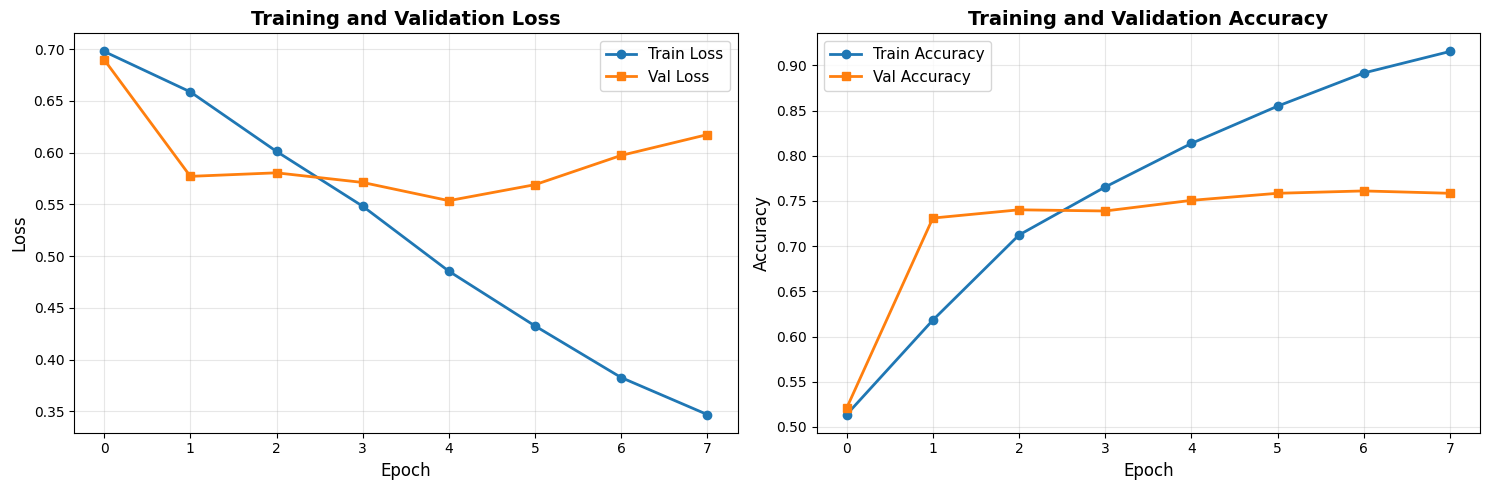

✓ Training history plot saved!


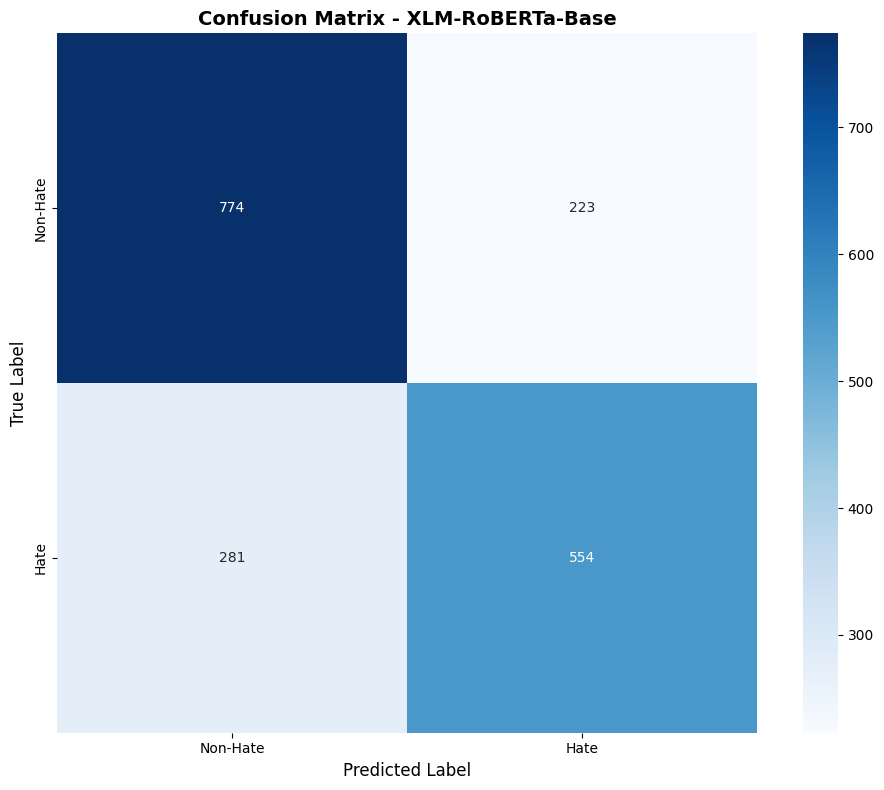

✓ Confusion matrix plot saved!


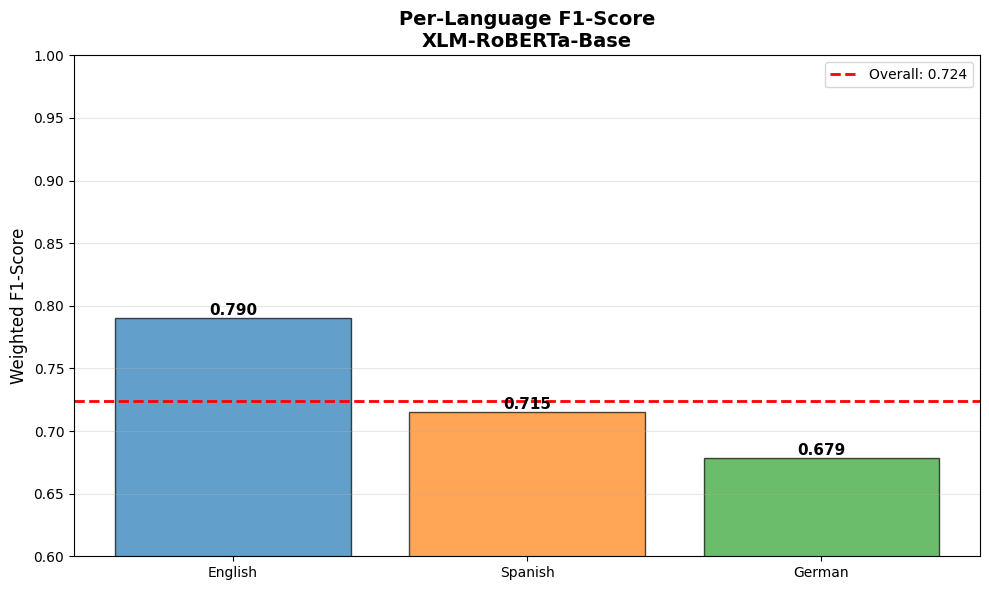

✓ Per-language F1 plot saved!

✓ All visualizations complete!


In [19]:
# ====================
# CELL 12: Visualizations
# ====================

# Create results directory
os.makedirs('results', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# Plot 1: Training History
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/training_history.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Training history plot saved!")

# Plot 2: Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True,
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - XLM-RoBERTa-Base', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/confusion_matrix.pdf', dpi=300, bbox_inches='tight')
plt.savefig('plots/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Confusion matrix plot saved!")

# Plot 3: Per-Language F1 Scores
# Recalculate per-language results for plotting
lang_f1_results = {}
test_preds_array = np.array(test_preds)
test_labels_array = np.array(test_labels)
test_df_reset = test_df.reset_index(drop=True)

for lang, lang_name in [('en', 'English'), ('es', 'Spanish'), ('de', 'German')]:
    lang_mask = test_df_reset['language'] == lang
    lang_indices = lang_mask[lang_mask].index.tolist()
    
    if len(lang_indices) > 0:
        lang_preds = test_preds_array[lang_indices]
        lang_labels = test_labels_array[lang_indices]
        lang_f1 = f1_score(lang_labels, lang_preds, average='weighted')
        lang_f1_results[lang_name] = lang_f1

if lang_f1_results:
    plt.figure(figsize=(10, 6))
    langs = list(lang_f1_results.keys())
    f1_scores = list(lang_f1_results.values())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    bars = plt.bar(langs, f1_scores, color=colors, alpha=0.7, edgecolor='black')
    plt.ylabel('Weighted F1-Score', fontsize=12)
    plt.title('Per-Language F1-Score\nXLM-RoBERTa-Base', fontsize=14, fontweight='bold')
    plt.ylim([0.6, 1.0])
    plt.axhline(y=weighted_f1, color='red', linestyle='--', 
                label=f'Overall: {weighted_f1:.3f}', linewidth=2)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    
    # Add value labels on bars
    for bar, f1_val in zip(bars, f1_scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{f1_val:.3f}',
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('plots/per_language_f1.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('plots/per_language_f1.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Per-language F1 plot saved!")

print("\n✓ All visualizations complete!")


In [20]:
# ====================
# CELL 13: Save Results & Final Summary
# ====================

# Save complete results to JSON
results = {
    'model': 'XLM-RoBERTa-Base',
    'task': 'Binary Hate Speech Detection',
    'configuration': CONFIG,
    'data_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_classes': num_classes,
        'languages': ['English', 'Spanish', 'German']
    },
    'training_history': {
        'train_loss': [float(x) for x in history['train_loss']],
        'train_acc': [float(x) for x in history['train_acc']],
        'val_loss': [float(x) for x in history['val_loss']],
        'val_acc': [float(x) for x in history['val_acc']],
        'best_epoch': int(best_epoch),
        'best_val_acc': float(best_val_acc)
    },
    'test_results': {
        'accuracy': float(test_acc),
        'weighted_f1': float(weighted_f1),
        'macro_f1': float(macro_f1),
        'precision': float(precision_recall_fscore_support(test_labels, test_preds, average='weighted')[0]),
        'recall': float(precision_recall_fscore_support(test_labels, test_preds, average='weighted')[1]),
        'loss': float(test_loss)
    },
    'per_language_f1': lang_f1_results
}

# Save to JSON
with open('results/xlm_roberta_base_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✓ Results saved to: results/xlm_roberta_base_results.json")

# Final Summary
print("\n" + "="*70)
print("FINAL SUMMARY - XLM-RoBERTa-Base")
print("="*70)
print(f"Task: Binary Hate Speech Detection")
print(f"  Class 0: Non-hate speech")
print(f"  Class 1: Hate speech")
print(f"\nModel: XLM-RoBERTa-Base (~278M parameters)")
print(f"Languages: English, Spanish, German")
print(f"Training samples: {len(train_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"\nBest Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"\nTest Performance (F1-Score Priority):")
print(f"  Weighted F1: {weighted_f1:.4f} ⭐")
print(f"  Macro F1:    {macro_f1:.4f}")
print(f"  Accuracy:    {test_acc:.4f}")
print(f"\nPer-Language F1-Scores:")
for lang, f1_val in lang_f1_results.items():
    print(f"  {lang}: {f1_val:.4f}")
print("="*70)
print("\n✓ All files saved:")
print("  - Model: best_xlm_roberta_base_model.pt")
print("  - Results: results/xlm_roberta_base_results.json")
print("  - Plots: plots/training_history.pdf")
print("  - Plots: plots/confusion_matrix.pdf")
print("  - Plots: plots/per_language_f1.pdf")
print("\n Training and evaluation complete!")


✓ Results saved to: results/xlm_roberta_base_results.json

FINAL SUMMARY - XLM-RoBERTa-Base
Task: Binary Hate Speech Detection
  Class 0: Non-hate speech
  Class 1: Hate speech

Model: XLM-RoBERTa-Base (~278M parameters)
Languages: English, Spanish, German
Training samples: 6,890
Test samples: 1,832

Best Validation Accuracy: 0.7611 (Epoch 7)

Test Performance (F1-Score Priority):
  Weighted F1: 0.7238 ⭐
  Macro F1:    0.7209
  Accuracy:    0.7249

Per-Language F1-Scores:
  English: 0.7900
  Spanish: 0.7149
  German: 0.6785

✓ All files saved:
  - Model: best_xlm_roberta_base_model.pt
  - Results: results/xlm_roberta_base_results.json
  - Plots: plots/training_history.pdf
  - Plots: plots/confusion_matrix.pdf
  - Plots: plots/per_language_f1.pdf

 Training and evaluation complete!
